In [13]:
from IPython.display import clear_output

In [14]:
import time
import numpy as np
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from scipy.linalg import norm, pinv
from scipy import fft
from tqdm import tqdm, trange

In [15]:
import torch
from torch.nn.functional import relu, mse_loss, conv1d
from torch.nn import Module, ReLU

device = torch.device('cuda')
print(device)

cuda


In [16]:
class sparse_dataset(Dataset):
    def __init__(self, N, K, Nexamples, sig=0.0, A=None):
        self.X = np.zeros((Nexamples, N, 1))
        for ii in range(Nexamples):
            print("{}/{}".format(ii, Nexamples))
            self.X[ii,...] = self.generate_sparse_vector(N, K)
        #self.X *= np.random.randn(*self.X.shape)
        self.X = torch.from_numpy(self.X).reshape(Nexamples, N)
        print(self.X.shape)
        self.Y = self.X @ A.T
        print(self.Y.shape)
    
    def __getitem__(self, i):
        return (self.X[i, ...], self.Y[i, ...])
    
    def __len__(self, ):
        return self.X.shape[0]
    
    def generate_sparse_vector(self, N, K):
        x = np.zeros((N,1))
        x[:K,...] = 1.
        np.random.shuffle(x)
        return x

In [17]:
# Create training data
maxit = 10
M = 64
N = 512
sig = 0.4
epochs = 10
batchSize = 10
testFreq = 1
trainingPoints = 100
testingPoints = 100
sparsityLevel = 5

# Create ULA and Nested Array Matricies
N1 = M // 2
N2 = M - N1

inner = np.arange(N1)
outer = np.arange(1, N2+1)*(N1 + 1) - 1

uniform = np.arange(M).reshape(-1,1)
nested = np.concatenate([inner, outer]).reshape(-1, 1)

fgrid = fft.fftfreq(N).reshape(-1, 1)

complex_exp = lambda x : np.exp(1j* 2*np.pi * x )
A_u = complex_exp(uniform @ fgrid.T)
A_n = complex_exp(nested @ fgrid.T)

dataset_training = sparse_dataset(N, sparsityLevel, trainingPoints, A=A_u)
dataloader_training = DataLoader(dataset_training, 
                                 batch_size = batchSize, shuffle=True)
dataset_testing = sparse_dataset(N, sparsityLevel, testingPoints, A=A_u)
dataloader_testing = DataLoader(dataset_testing, 
                                 batch_size = testingPoints, shuffle=False)
batches = int(trainingPoints/batchSize)
training_losslist = np.zeros(epochs * batches)
testing_losslist = np.zeros(epochs * batches)

0/100
1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100
torch.Size([100, 512])
torch.Size([100, 64])
0/100
1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39

In [18]:
torch.save(dataset_training, "training_data.pt")
torch.save(dataset_testing, "testing_data.pt")

In [19]:
class ComplexLISTA(Module):
    
    def __init__(self, M, N, maxit):
        super(ComplexLISTA, self).__init__()
    
        # Real and imaginary Wg and We matricies 
        self.Wre = torch.nn.Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wrg = torch.nn.Parameter(torch.zeros([maxit+1, N, N]), requires_grad=True)
        self.Wie = torch.nn.Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wig = torch.nn.Parameter(torch.zeros([maxit+1, N, N]), requires_grad=True)
        
        # alpha and lambda hyper-parameters to LASSO/ISTA
        #self.alpha = torch.nn.Parameter(torch.zeros(maxit), requires_grad=True)
        #self.lamda = torch.nn.Parameter(torch.zeros(maxit), requires_grad=True)
        self.theta = torch.nn.Parameter(torch.ones(maxit+1), requires_grad=True)
        
        # Save the passed values
        self.M = M
        self.N = N
        self.maxit = maxit
        self.relu = ReLU()

        return
    
    def forward(self, yr, yi, epsilon=1e-10):
        
        Wret = torch.transpose(self.Wre[0], 0, 1)
        Wiet = torch.transpose(self.Wie[0], 0, 1)
        Wrgt = torch.transpose(self.Wrg[0], 0, 1)
        Wigt = torch.transpose(self.Wig[0], 0, 1)
                
        # Apply We branch to y to 0-th iteration
        zr = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
        zi = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
        
        # Apply soft-thresholding according to Eldar's paper.
        xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
        xr = torch.divide(zr, xabs + 1) * self.relu(xabs - self.theta[0])
        xi = torch.divide(zi, xabs + 1) * self.relu(xabs - self.theta[0])

        #soft = torch.divide(self.theta[0], self.theta[0])
        #soft = torch.divide(self.theta[0], torch.max(xabs, self.theta[0]))
        #soft = 1 - torch.divide(self.theta[0], relu(xabs - self.theta[0]) + self.theta[0]) 
        #soft = 1 - torch.divide(self.theta[0], self.relu(xabs - self.theta[0]) + self.theta[0]) 
        #xr = torch.multiply(zr, softr)
        #xi = torch.multiply(zi,  softi)
        
        
        for t in range(1, self.maxit+1):
            
            Wret = torch.transpose(self.Wre[0], 0, 1)
            Wiet = torch.transpose(self.Wie[0], 0, 1)
            Wrgt = torch.transpose(self.Wrg[0], 0, 1)
            Wigt = torch.transpose(self.Wig[0], 0, 1)
        
            # Apply We branch to y to t-th iteration
            ar = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
            ai = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
            
            # Apply Wg branch to x^(t) for t-th iteration
            br = torch.matmul(xr, Wrgt) - torch.matmul(xi, Wigt)
            bi = torch.matmul(xi, Wrgt) + torch.matmul(xr, Wigt)
            
            # Add the two branches                                                                           
            zr = ar + br
            zi = ai + bi
            
            # Apply soft-thresholding
            xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
            #xr = zr * torch.pinverse(xabs).t() * self.relu(xabs - self.theta[t])
            #xi = zi * torch.pinverse(xabs).t() * self.relu(xabs - self.theta[t])
            xr = torch.divide(zr, xabs + 1) * self.relu(xabs - self.theta[t])
            xi = torch.divide(zi, xabs + 1) * self.relu(xabs - self.theta[t])
            #soft = torch.divide(self.theta[t], self.theta[t]) 
            #soft = torch.divide(self.theta[t], torch.max(xabs, self.theta[t]))
            #soft = 1 - torch.divide(self.theta[t], self.relu(xabs - self.theta[t]) + self.theta[t]) 
            #soft = 1
            #xr = torch.multiply(zr, softr)
            #xi = torch.multiply(zi, softi)
            
            #print(f"{yr[0,0] = }, {zr[0,0] = }, {xr[0,0] = }, {self.theta[0] = }, {soft[0,0] = }, {self.Wre[0,0] = }, {self.Wrg[0,0] = }")
      
        return xr, xi

In [20]:
class ComplexLISTA_Toeplitz(Module):
    
    def __init__(self, M, N, maxit):
        super(ComplexLISTA, self).__init__()
    
        # Real and imaginary Wg and We matricies 
        self.Wre = torch.nn.Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wie = torch.nn.Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.hrg = torch.nn.Parameter(torch.zeros([maxut+1, N]), requires_grad=True)
        self.hig = torch.nn.Parameter(torch.zeros([maxit+1, N]), requires_grad=True)
        
        # alpha and lambda hyper-parameters to LASSO/ISTA
        #self.alpha = torch.nn.Parameter(torch.zeros(maxit), requires_grad=True)
        #self.lamda = torch.nn.Parameter(torch.zeros(maxit), requires_grad=True)
        self.theta = torch.nn.Parameter(torch.ones(maxit+1), requires_grad=True)
        
        # Save the passed values
        self.M = M
        self.N = N
        self.maxit = maxit
        self.relu = ReLU()

        return
    
    def forward(self, yr, yi, epsilon=1e-10):
        
        Wret = torch.transpose(self.Wre[0], 0, 1)
        Wiet = torch.transpose(self.Wie[0], 0, 1)
                
        # Apply We branch to y to 0-th iteration
        zr = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
        zi = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
        
        # Apply soft-thresholding according to Eldar's paper.
        xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
        xr = torch.divide(zr, xabs + 1) * self.relu(xabs - self.theta[0])
        xi = torch.divide(zi, xabs + 1) * self.relu(xabs - self.theta[0])

        #soft = torch.divide(self.theta[0], self.theta[0])
        #soft = torch.divide(self.theta[0], torch.max(xabs, self.theta[0]))
        #soft = 1 - torch.divide(self.theta[0], relu(xabs - self.theta[0]) + self.theta[0]) 
        #soft = 1 - torch.divide(self.theta[0], self.relu(xabs - self.theta[0]) + self.theta[0]) 
        #xr = torch.multiply(zr, softr)
        #xi = torch.multiply(zi,  softi)
        
        
        for t in range(1, self.maxit+1):

            Wret = torch.transpose(self.Wre[t], 0, 1)
            Wiet = torch.transpose(self.Wie[t], 0, 1)
            hrgt = self.hrg[t]
            higt = self.hig[t]
        
            # Apply We branch to y to t-th iteration
            ar = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
            ai = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
            
            # Apply hg conv1d branch to x^(t) for t-th iteration
            br = conv1d(xr, hrgt) - conv1d(xi, higt)
            bi = conv1d(xi, hrgt) + conv1d(xr, hight)
            
            # Add the two branches                                                                           
            zr = ar + br
            zi = ai + bi
            
            # Apply soft-thresholding
            xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
            #xr = zr * torch.pinverse(xabs).t() * self.relu(xabs - self.theta[t])
            #xi = zi * torch.pinverse(xabs).t() * self.relu(xabs - self.theta[t])
            xr = torch.divide(zr, xabs + 1) * self.relu(xabs - self.theta[t])
            xi = torch.divide(zi, xabs + 1) * self.relu(xabs - self.theta[t])
            #soft = torch.divide(self.theta[t], self.theta[t]) 
            #soft = torch.divide(self.theta[t], torch.max(xabs, self.theta[t]))
            #soft = 1 - torch.divide(self.theta[t], self.relu(xabs - self.theta[t]) + self.theta[t]) 
            #soft = 1
            #xr = torch.multiply(zr, softr)
            #xi = torch.multiply(zi, softi)
            
            #print(f"{yr[0,0] = }, {zr[0,0] = }, {xr[0,0] = }, {self.theta[0] = }, {soft[0,0] = }, {self.Wre[0,0] = }, {self.Wrg[0,0] = }")
      
        return xr, xi

In [21]:
model = ComplexLISTA(M, N, maxit)

# for name, weights in model.named_parameters():
#     print(name, weights)
#print(model.state_dict())

In [22]:
# Initialize Wg matrix according to Eldar
X, Y = dataset_training[:100]
print(X.shape, Y.shape)
X = X.numpy().T
Y = Y.numpy().T
XHX = X.T.conj() @ X 
XHXinv = pinv(XHX)
Phi = Y @ XHXinv @ X.T.conj() # conjugates omitted since X will be real
PhiH = torch.from_numpy(Phi.conj().T)
L = np.max(np.abs(np.linalg.eigvals(Phi.conj().T @ Phi)))

#print(model.state_dict()['Wre'])
with torch.no_grad():
    for name, param in model.named_parameters():
        if 'Wre' in name:
            param.copy_(1/L * PhiH.real)
        if 'Wie' in name:
            param.copy_(1/L * PhiH.imag)
        if 'theta' in name:
            param.copy_(0.01/L * torch.ones(model.maxit+1))

print(model.state_dict()['Wre'][0])
print(model.state_dict()['Wre'][-1])

torch.Size([100, 512]) torch.Size([100, 64])
tensor([[ 0.0045,  0.0009,  0.0035,  ...,  0.0019, -0.0002,  0.0036],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0036,  0.0012,  0.0014,  ...,  0.0011, -0.0003,  0.0011],
        ...,
        [ 0.0012, -0.0007,  0.0010,  ...,  0.0008, -0.0010,  0.0006],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0012,  0.0007,  0.0001,  ...,  0.0010,  0.0018,  0.0036]])
tensor([[ 0.0045,  0.0009,  0.0035,  ...,  0.0019, -0.0002,  0.0036],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0036,  0.0012,  0.0014,  ...,  0.0011, -0.0003,  0.0011],
        ...,
        [ 0.0012, -0.0007,  0.0010,  ...,  0.0008, -0.0010,  0.0006],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0012,  0.0007,  0.0001,  ...,  0.0010,  0.0018,  0.0036]])


In [23]:
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
obj = torch.nn.MSELoss()
t = trange(epochs)
for e in t:
    for i, data in enumerate(dataloader_training):

        idx = e * batches + i
        x, y = data
        
        # Split data to real and complex
        xr = x.to(torch.float32)
        xi = torch.zeros_like(xr).to(torch.float32)
        
        yr = y.real.to(torch.float32)
        yi = y.imag.to(torch.float32)
        
        # Send through model
        xpredr, xpredi = model(yr, yi)
        
        loss = obj(xpredr, xr) + obj(xpredi, xi)

        with torch.no_grad():
            training_losslist[idx] = loss

        loss.backward()    
        optim.step()
        optim.zero_grad()
        
        if testFreq and idx % testFreq == 0:
            for k, test_data in enumerate(dataloader_testing):
                
                x, y = test_data
                
                xr = x.to(torch.float32)
                xi = torch.zeros_like(xr).to(torch.float32)
                
                yr = y.real.to(torch.float32)
                yi = y.imag.to(torch.float32)
                
                model.eval()
                xpredr, xpredi = model(yr, yi)
                xpredr = xpredr.detach()
                xpredi = xpredi.detach()

                testing_losslist[idx] += torch.mean((xpredr.cpu() - xr.cpu())**2) + torch.mean((xpredi.cpu() - xi.cpu())**2)
                t.set_description("Training Loss: {}\t Validation Loss: {}".format(training_losslist[idx], testing_losslist[idx]), refresh=True)

        #clear_output(wait=True)
        #print("Epoch: {}\t Batch: {}\t Training Loss: {}\t Validation Loss: {}".format(e, i, training_losslist[idx], testing_losslist[idx]))

        #print("Epoch: {}\t Batch: {}\t Training Loss: {}\t".format(e, i, training_losslist[idx]), end='\r')

Training Loss: 0.0049883900210261345	 Validation Loss: 0.00938715972006321: 100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


0.009014662355184555


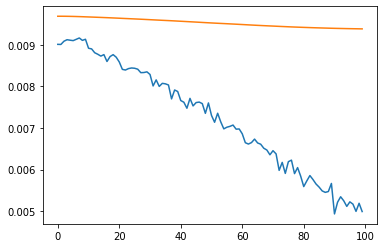

In [25]:
print(training_losslist[0])
plt.plot(training_losslist)
plt.plot(testing_losslist)
torch.save(model.state_dict(), "model_weights.pt")

In [26]:
# ''' Manually Set Values for Normal ISTA '''
# model_ista = ComplexLISTA(M, N, 1)
# L = np.max(np.abs(np.linalg.eigvals(A_u.conj().T @ A_u)))
# lambb = 1
# P = A_u.conj().T @ A_u
# We = 1/L * A_u.conj().T
# Wg = (np.eye(P.shape[0]) - 1/L * P)
# with torch.no_grad():
#     for name, param in model_ista.named_parameters():
#         if 'Wre' in name:
#             param.copy_(1/L * torch.from_numpy(We.real))
#         if 'Wie' in name:
#             param.copy_(1/L * torch.from_numpy(We.imag))
#         if 'Wrg' in name:
#             param.copy_(1/L * torch.from_numpy(Wg.real))
#         if 'Wig' in name:
#             param.copy_(1/L * torch.from_numpy(Wg.imag))
#         if 'theta' in name:
#             param.copy_(lambb/L * torch.ones(model_ista.maxit+1))
            
# print(model_ista.state_dict())


In [27]:
x_test, y_test = dataset_testing[2]

yr = y_test.real.to(torch.float32)
yi = y_test.imag.to(torch.float32)

model.eval()
xpredr, xpredi = model(yr, yi)
# xistar, xistai = model_ista(yr, yi)

x_test = x_test.numpy()
x_pred = np.zeros_like(x_test, dtype=complex)
x_pred.real = xpredr.detach().numpy()
x_pred.imag = xpredi.detach().numpy()

# x_ista = np.zeros_like(x_test, dtype=complex)
# x_ista.real = xistar.detach().numpy()
# x_ista.imag = xistai.detach().numpy()

S_test = np.abs(x_test)
S_pred = np.abs(x_pred)
# S_ista = np.abs(x_ista)

S_test /= S_test.max()
S_pred /= S_pred.max()
# S_ista /= S_ista.max()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


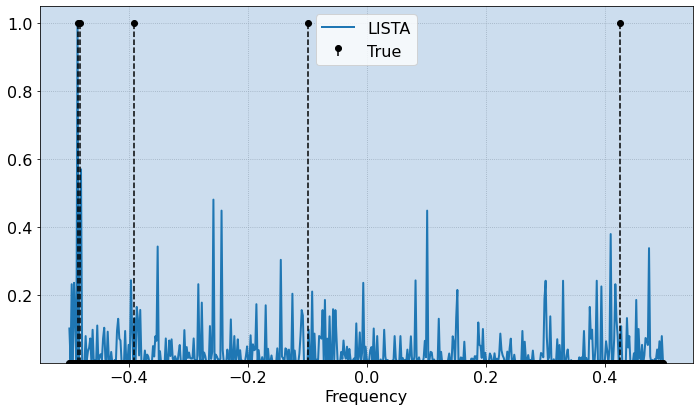

In [28]:
# Plot ULA
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(fft.fftshift(fft.fftfreq(N)), fft.fftshift(S_pred), linewidth=2, label='LISTA')
#ax.plot(fft.fftshift(fft.fftfreq(N)), fft.fftshift(S_ista), linewidth=2, label='ISTA')
ax.stem(fft.fftshift(fft.fftfreq(N)), fft.fftshift(S_test), 'k', markerfmt='ko', linefmt='k--', label='True',  basefmt=" ")
y1, y2 = ax.get_ylim()
#ax.vlines(fft.fftshift(fft.fftfreq(N)[np.nonzero(S_test)]), linestyle='--', ymin=0, ymax=y2, color='k', label='True')
ax.set_ylim(0.001, y2)
ax.set_xlabel('Frequency')
ax.set_title('')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

ax.legend()
plt.tight_layout()
plt.show()